In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install --upgrade --force-reinstall numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 111.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6

In [ ]:
#!pip install numpy==1.25.2 scipy==1.11.4

In [ ]:
!pip install https://github.com/podgorskiy/dnnlib/releases/download/0.0.1/dnnlib-0.0.1-py3-none-any.whl

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import dnnlib
import seaborn as sns
from PIL import Image
import random
from IPython.display import display as ipy_display
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider
from tqdm import tqdm
import json
import numpy as np
import scipy
import warnings
import threading
import glob, time
import sys

In [ ]:
sys.path.insert(0, '/content/stylegan2-ada-pytorch')

In [ ]:
print("Torch:", torch.__version__)
print("CUDA dispo:", torch.cuda.is_available())
print("NumPy:", np.__version__)
print("SciPy:", scipy.__version__)

Torch: 2.6.0+cu124
CUDA dispo: True
NumPy: 1.26.4
SciPy: 1.11.4


In [ ]:
!pip install pyspng tqdm requests click

## Mount and Prepare Dataset Files

In [ ]:
# Chemin vers zip dans Drive
zip_path = '/content/drive/MyDrive/fairface/fairface-img-margin025-trainval.zip'

In [ ]:
# Dossier où décompresser dans Colab local
extract_folder = '/content/dataset'

In [ ]:
# Créer le dossier d'extraction s'il n'existe pas
os.makedirs(extract_folder, exist_ok=True)


# Copier le zip dans local
!cp "{zip_path}" /content/

In [ ]:
# Décompression
!unzip -q "{zip_path}" -d "{extract_folder}"

print("Décompression terminée !")

replace /content/dataset/train/1346.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Décompression terminée !


##  Count Images in Dataset Folder

In [ ]:
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}

def count_images(folder):
    count = 0
    for root, dirs, files in os.walk(folder):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                count += 1
    return count

folder_path = "/content/dataset"
num_images = count_images(folder_path)
print(f"Nombre d'images dans '{folder_path}': {num_images}")

Nombre d'images dans '/content/dataset': 97698


## Copy and Load CSV Labels

In [ ]:
!cp "/content/drive/MyDrive/fairface/fairface_label_train.csv" /content/dataset/

In [ ]:
csv_path = "/content/dataset/fairface_label_train.csv"
df = pd.read_csv(csv_path)
# Aperçu des données
print("Aperçu des annotations :")
display(df.head())

Aperçu des annotations :


,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


## EDA (Exploratory Data Analysis)

In [ ]:
# Statistiques descriptives
print("\nStatistiques descriptives :")
print(df.describe())


Statistiques descriptives :
                   file    age gender   race service_test
count             86744  86744  86744  86744        86744
unique            86744      9      2      7            2
top     train/86744.jpg  20-29   Male  White        False
freq                  1  25598  45986  16527        46492


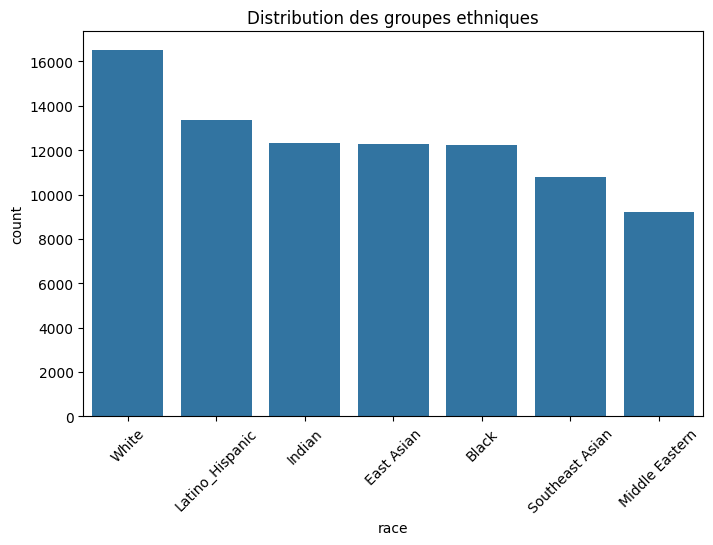

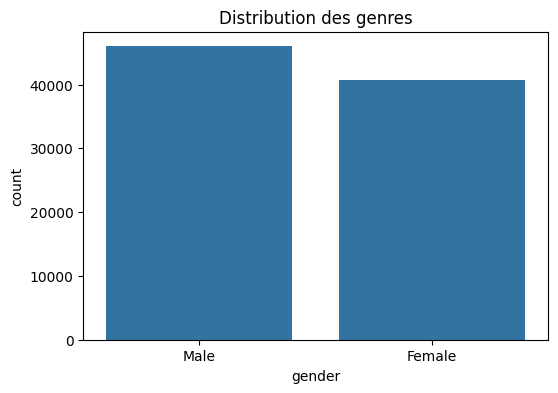

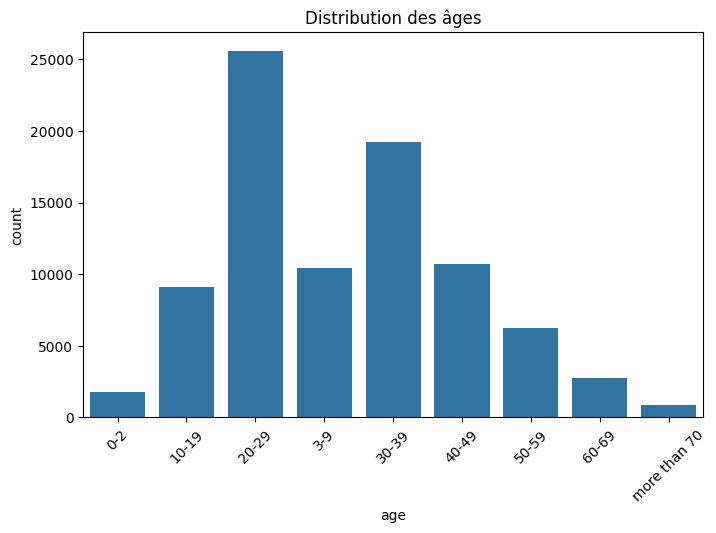

In [ ]:
# Distribution des groupes ethniques
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='race', order=df['race'].value_counts().index)
plt.title("Distribution des groupes ethniques")
plt.xticks(rotation=45)
plt.show()

# Distribution des genres
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='gender')
plt.title("Distribution des genres")
plt.show()

# Distribution des âges
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='age', order=df['age'].value_counts().sort_index().index)
plt.title("Distribution des âges")
plt.xticks(rotation=45)
plt.show()

Race: Latino_Hispanic, Gender: Female, Age: 10-19


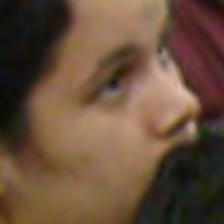

Race: East Asian, Gender: Female, Age: 20-29


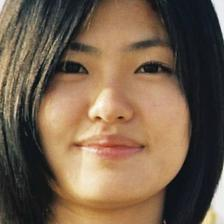

Race: Black, Gender: Female, Age: 10-19


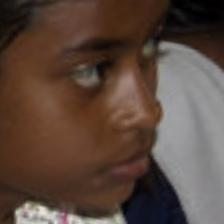

Race: Southeast Asian, Gender: Female, Age: 3-9


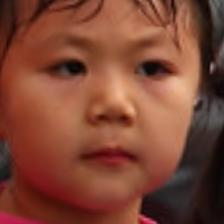

Race: Indian, Gender: Male, Age: 20-29


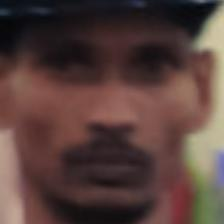

In [ ]:
image_folder = "/content/dataset"

sample = df.sample(5)
for idx, row in sample.iterrows():
    img_path = os.path.join(image_folder, row['file'])
    if os.path.exists(img_path):
        img = Image.open(img_path)  # PIL ouvre l’image
        print(f"Race: {row['race']}, Gender: {row['gender']}, Age: {row['age']}")
        ipy_display(img)  # affichage dans notebook
    else:
        print(f"Image manquante: {img_path}")

## Loading and Encoding FairFace Images and Attributes

In [ ]:
class FairFaceDataset(Dataset):
  """
    Dataset PyTorch pour le jeu de données FairFace.
    Charge les images et les attributs associés (âge, genre, ethnie),
    convertit les attributs en vecteurs continus appelés "sliders" pour un usage
    dans un modèle conditionnel (ex: StyleGAN2 conditionnel).

    Attributs principaux :
    - csv_file : chemin vers le fichier CSV contenant les métadonnées.
    - images_folder : dossier contenant les images.
    - transform : transformations appliquées aux images (resize, tensor, etc).

    Fonctionnalités clés :
    - Filtrage des données pour ne garder que les tranches d'âge 10-19 ans et >= 18 ans.
    - Conversion de l'âge en valeur normalisée continue entre 0 et 1.
    - Encodage simple du genre (Male=0.0, Female=1.0).
    - Conversion de l'ethnie en float entre 0 et 1 selon un ordre prédéfini (peau claire à foncée).
    - Chargement et transformation des images RGB.
    - Retourne à chaque itération une image et un vecteur slider (âge, genre, ethnie).

    Méthodes :
    - __len__ : retourne le nombre d'exemples disponibles.
    - __getitem__ : retourne l'image transformée et les sliders pour un index donné.
    - age_to_slider : convertit une tranche d'âge en valeur flottante normalisée.
    """
  def __init__(self, csv_file, images_folder, transform=None):
    self.df = pd.read_csv(csv_file)
    # Mappages pour sliders et âge
    self.age_midpoints = {
        "0-2": 1,
        "3-9": 6,
        "10-19": 14.5,
        "20-29": 24.5,
        "30-39": 34.5,
        "40-49": 44.5,
        "50-59": 54.5,
        "60-69": 64.5,
        "70+": 75
    }
    self.age_min = 18
    self.age_max = 70
    # Filtrer en gardant la tranche "10-19" et toutes celles >= 18 ans
    def age_filter(age_range):
        if age_range == "10-19":
            return True  # garder cette tranche
        mid = self.age_midpoints.get(age_range, None)
        return mid is not None and mid >= self.age_min

    self.df = self.df[self.df['age'].apply(age_filter)].reset_index(drop=True)

    # Encodage simple pour genre (Male=0, Female=1)
    self.gender_map = {"Male": 0.0, "Female": 1.0}

    # Liste fixe ordonnée des ethnies FairFace du plus clair au plus foncé
    self.ordered_ethnies = [
        "White",
        "Middle Eastern",
        "Indian",
        "Latino_Hispanic",
        "Southeast Asian",
        "East Asian",
        "Black"
    ]

    # Mapping ethnie -> float dans [0,1] pour slider peau cohérent
    self.skin_map = {eth: i / (len(self.ordered_ethnies) - 1) for i, eth in enumerate(self.ordered_ethnies)}

    self.images_folder = images_folder
    self.transform = transform

  def age_to_slider(self, age_range_str):
    if age_range_str == "10-19":
        # Partie 18-19 pour slider
        age_start = 18
        age_end = 19
        slider_start = 0.0
        slider_end = (age_end - self.age_min) / (self.age_max - self.age_min)
        return (slider_start + slider_end) / 2

    age_mid = self.age_midpoints.get(age_range_str, self.age_min)
    age_clamped = max(min(age_mid, self.age_max), self.age_min)
    return (age_clamped - self.age_min) / (self.age_max - self.age_min)

  def __len__(self):
        return len(self.df)

  def __getitem__(self, idx):
      row = self.df.iloc[idx]
      img_path = f"{self.images_folder}/{row['file']}"
      image = Image.open(img_path).convert("RGB")

      if self.transform:
          image = self.transform(image)

      age_slider = torch.tensor(self.age_to_slider(row['age']), dtype=torch.float32)
      gender_slider = torch.tensor(self.gender_map.get(row['gender'], 0.0), dtype=torch.float32)

      # Si ethnie inconnue, mettre à 0.0 par défaut
      skin_slider = torch.tensor(self.skin_map.get(row['race'], 0.0), dtype=torch.float32)

      sliders = torch.stack([age_slider, gender_slider, skin_slider])

      return image, sliders

In [ ]:
class FairFaceSliderDataset(FairFaceDataset):
  """
    Dataset personnalisé pour le jeu de données FairFace, avec mise à l'échelle
    des images et retour des valeurs de type "sliders".

    Cette classe hérite de `FairFaceDataset` et applique une transformation
    supplémentaire aux images : redimensionnement à une taille fixe et
    conversion en tenseur PyTorch. Les étiquettes (sliders) associées aux
    images sont conservées telles que fournies par la classe parente.

    Paramètres
    ----------
    csv_path : str
        Chemin vers le fichier CSV contenant les chemins d'accès aux images
        et leurs annotations associées.
    image_dir : str
        Chemin vers le répertoire racine contenant les fichiers image.
    image_size : int, optionnel (défaut = 128)
        Taille de sortie (hauteur et largeur) des images après redimensionnement.
  """
  def __init__(self, csv_path, image_dir, image_size=128):
      super().__init__(csv_path, image_dir)
      self.transform = T.Compose([
          T.Resize((image_size, image_size)),
          T.ToTensor(),
      ])

  def __getitem__(self, idx):
      image, sliders = super().__getitem__(idx)
      image = self.transform(image)
      return image, sliders

##  Dataset and DataLoader Setup

{0.0: 'White', 0.16666666666666666: 'Middle Eastern', 0.3333333333333333: 'Indian', 0.5: 'Latino_Hispanic', 0.6666666666666666: 'Southeast Asian', 0.8333333333333334: 'East Asian', 1.0: 'Black'}


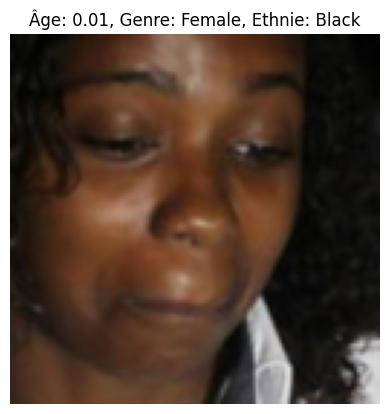

FloatSlider(value=0.009615384973585606, description='Âge', disabled=True, max=1.0, step=0.01)

FloatSlider(value=1.0, description='Genre', disabled=True, max=1.0, step=0.01)

FloatSlider(value=1.0, description='Ethnie', disabled=True, max=1.0, step=0.01)

In [ ]:
# Transformations
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
])

dataset = FairFaceDataset(
    csv_file="/content/dataset/fairface_label_train.csv",
    images_folder="/content/dataset",
    transform=transform
)

loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Inverse mapping pour retrouver la catégorie ethnie depuis la valeur float
inv_skin_map = {v: k for k, v in dataset.skin_map.items()}
print(inv_skin_map)

def get_closest_ethnie_label(val):
    closest_val = min(inv_skin_map.keys(), key=lambda x: abs(x - val.item()))
    return inv_skin_map[closest_val]

for images, sliders in loader:
    img_tensor = images[0]
    sliders_vals = sliders[0]

    img = TF.to_pil_image(img_tensor)

    age_val = sliders_vals[0].item()
    gender_val = sliders_vals[1].item()
    skin_val = sliders_vals[2]

    gender_label = "Female" if gender_val > 0.5 else "Male"
    skin_label = get_closest_ethnie_label(skin_val)

    age_slider = widgets.FloatSlider(value=age_val, min=0, max=1, step=0.01, description='Âge', disabled=True)
    gender_slider = widgets.FloatSlider(value=gender_val, min=0, max=1, step=0.01, description='Genre', disabled=True)
    skin_slider = widgets.FloatSlider(value=skin_val.item(), min=0, max=1, step=0.01, description='Ethnie', disabled=True)

    plt.imshow(img)
    plt.title(f"Âge: {age_val:.2f}, Genre: {gender_label}, Ethnie: {skin_label}")
    plt.axis('off')
    plt.show()

    display(age_slider, gender_slider, skin_slider)
    break

In [ ]:
%cd /content

/content


## Clone & Patch StyleGAN2-ADA

In [ ]:
!rm -f /usr/local/lib/python3.11/dist-packages/legacy.py

In [ ]:
!rm -rf stylegan2-ada-pytorch
!git clone https://github.com/rkuo2000/stylegan2-ada-pytorch

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 151, done.
remote: Total 151 (delta 0), reused 0 (delta 0), pack-reused 151 (from 1)
Receiving objects: 100% (151/151), 1.13 MiB | 2.90 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [ ]:
# Download the updated conv2d_gradfix.py
!wget -O stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py \
  https://raw.githubusercontent.com/NVlabs/stylegan3/main/torch_utils/ops/conv2d_gradfix.py

# Download the updated grid_sample_gradfix.py (note: file renamed from grid_simple_gradfix.py)
!wget -O stylegan2-ada-pytorch/torch_utils/ops/grid_sample_gradfix.py \
  https://raw.githubusercontent.com/NVlabs/stylegan3/main/torch_utils/ops/grid_sample_gradfix.py

--2025-08-08 08:30:08--  https://raw.githubusercontent.com/NVlabs/stylegan3/main/torch_utils/ops/conv2d_gradfix.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9745 (9.5K) [text/plain]
Saving to: ‘stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py’

stylegan2-ada-pytor 100%[===================>]   9.52K  --.-KB/s    in 0s      

2025-08-08 08:30:09 (94.1 MB/s) - ‘stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py’ saved [9745/9745]

--2025-08-08 08:30:09--  https://raw.githubusercontent.com/NVlabs/stylegan3/main/torch_utils/ops/grid_sample_gradfix.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

## Install Python Packages

In [ ]:
!pip install timm==0.4.12 ftfy==6.1.1 ninja==1.10.2 imageio-ffmpeg==0.4.3 opensimplex i

## Prepare Dataset (FairFace, resized to 128x128)

In [ ]:
src_folder = "/content/dataset"
dest_folder = "/content/fairface-128x128"
os.makedirs(dest_folder, exist_ok=True)

resize_dim = (128, 128)
label_list = []

for i, row in tqdm(dataset.df.iterrows(), total=len(dataset.df)):
    file_name = row['file']
    src_path = os.path.join(src_folder, file_name)
    dst_path = os.path.join(dest_folder, file_name)

    if not os.path.exists(src_path):
        continue

    os.makedirs(os.path.dirname(dst_path), exist_ok=True)

    try:
        img = Image.open(src_path).convert("RGB")
        img = img.resize(resize_dim)
        img.save(dst_path)

        # Générer les labels correspondants
        age_slider = dataset.age_to_slider(row['age'])
        gender_slider = dataset.gender_map.get(row['gender'], 0.0)
        skin_slider = dataset.skin_map.get(row['race'], 0.0)
        label_list.append([file_name, [age_slider, gender_slider, skin_slider]])

    except Exception as e:
        print(f"Erreur avec {src_path}: {e}")

# Sauvegarder dataset.json
label_json = {"labels": label_list}
with open(os.path.join(dest_folder, "dataset.json"), "w") as f:
    json.dump(label_json, f)

print("Fichier dataset.json sauvegardé avec les labels.")



100%|██████████| 73702/73702 [02:03<00:00, 597.51it/s]


Fichier dataset.json sauvegardé avec les labels.


## Convert Dataset to LMDB

In [ ]:
!python /content/stylegan2-ada-pytorch/dataset_tool.py --source /content/fairface-128x128 --dest /content/fairface_lmdb --width 128 --height 128 --transform center-crop

  0% 0/73702 [00:00<?, ?it/s]/content/stylegan2-ada-pytorch/dataset_tool.py:220: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = PIL.Image.fromarray(img, 'RGB')
/content/stylegan2-ada-pytorch/dataset_tool.py:429: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = PIL.Image.fromarray(img, { 1: 'L', 3: 'RGB' }[channels])
100% 73702/73702 [02:11<00:00, 559.49it/s]


## Installing PyTorch with CUDA 11.8 Support for GPU Acceleration

In [ ]:
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Train StyleGAN2-ADA (Conditional)

In [ ]:
os.environ["PYTHONWARNINGS"] = "ignore"

In [ ]:
# Dossier de sortie pour les résultats d'entraînement
output_dir = "/content/drive/MyDrive/stylegan2-runs"

# Dataset (images redimensionnées + dataset.json)
dataset_path = "/content/fairface-128x128"

def keep_only_latest_snapshot(folder, prefix):
    files = sorted(glob.glob(f"{folder}/{prefix}*"), key=os.path.getmtime)
    if len(files) > 1:
        for f in files[:-1]:
            os.remove(f)

def cleanup_loop(output_dir):
    while True:
        keep_only_latest_snapshot(output_dir, "network-snapshot-")
        keep_only_latest_snapshot(output_dir, "fakes")
        time.sleep(60)  # Every 60 seconds

# Run cleanup in parallel thread
threading.Thread(target=cleanup_loop, args=(output_dir,), daemon=True).start()

In [ ]:
# Lancement de l'entraînement conditionnel StyleGAN2-ADA

!python /content/stylegan2-ada-pytorch/train.py \
  --outdir="$output_dir" \
  --data="$dataset_path" \
  --cond=True \
  --cfg=auto \
  --gpus=1 \
  --batch=32 \
  --snap=10 \
  --metrics=None \
  --kimg=300 \
  --resume="/content/drive/MyDrive/stylegan2-runs/00001-fairface-128x128-cond-auto1-kimg200-batch32/network-snapshot-000200.pkl"



Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 10,
  "network_snapshot_ticks": 10,
  "metrics": [],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/fairface-128x128",
    "use_labels": true,
    "max_size": 73702,
    "xflip": false,
    "resolution": 128
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 16384,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 16384,
    "channel_max": 512,
    "num_fp16_res

## Generation

In [ ]:
#!pip install https://github.com/podgorskiy/dnnlib/releases/download/0.0.1/dnnlib-0.0.1-py3-none-any.whl

In [ ]:
import legacy

# Charger le modèle
network_pkl = "/content/drive/MyDrive/stylegan2-runs/00004-fairface-128x128-cond-auto1-kimg300-batch32-resumecustom/network-snapshot-000280.pkl"
device = torch.device('cuda')

with open(network_pkl, 'rb') as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)

# Vecteur latent
z = torch.randn(1, G.z_dim, device=device)

# Fonction d'affichage interactive
def generate_and_show(age, gender, race):
    cond = torch.tensor([[age, gender, race]], device=device, dtype=torch.float32)

    with torch.no_grad():
        img_tensor = G(z, cond, truncation_psi=0.7, noise_mode='const')

    img = (img_tensor.clamp(-1, 1) + 1) * (255 / 2)
    img = img.permute(0, 2, 3, 1).to('cpu', torch.uint8).numpy()[0]
    img = Image.fromarray(img)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Sliders interactifs
interact(
    generate_and_show,
    age=FloatSlider(value=0, min=0.0, max=1.0, step=0.01, description='Age'),
    gender=FloatSlider(value=0, min=0.0, max=1.0, step=0.01, description='Gender'),
    race=FloatSlider(value=0, min=0.0, max=1.0, step=0.01, description='Race')
)

interactive(children=(FloatSlider(value=0.0, description='Age', max=1.0, step=0.01), FloatSlider(value=0.0, de…

<function __main__.generate_and_show(age, gender, race)>